# ***Deep Learning - Assignment 2***

Student name - Leor Ariel Rose, ID - 208373365

Student name - Aviv Rovshitz, ID - 307974162

### ***Import packages***

Let's begin with importing all necessary packages:

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras import utils
from matplotlib import pyplot as plt
from typing import Tuple, Callable
from sklearn.model_selection import train_test_split

### ***Constant definitions***

Next, let's define some constant variables:

In [2]:
# Define the path containing the Data 
# (lfw2 folder, pairsDevTest.txt, pairsDevTrain.txt)
DATA_PATH = "Data"

# Define the path containing the images (lfw2)
IMAGES_PATH = f"{DATA_PATH}/lfw2"

# Define the path to the pairsDevTrain text file
PAIRS_DEV_TRAIN_PATH = f"{DATA_PATH}/pairsDevTrain.txt"

# Define the path to the pairsDevTest text file
PAIRS_DEV_TEST_PATH = f"{DATA_PATH}/pairsDevTest.txt"

# Define original image shape
ORIGINAL_IMAGE_SHAPE = (250,250)

# Define padding for image name
LEADING_ZERO_PAD = 4

# Define the label value of match images
MATCH_LABEL = 1

# Define the label value of mismatch images
MISMATCH_LABEL = 0

# Define batch size
BATCH_SIZE = 32

# Define learning rate
LEARNING_RATE = 0.0001

# Define number of epochs
NUM_EPOCHS = 200

### ***Auxiliary methods***

Next, let's define some auxiliary methods:


In [3]:
def parse_data(file_path: str) -> Tuple[np.ndarray, np.ndarray]:
  """ Function to read the development training/testing 
        sets depending the given file path.

    Args:
        file_path (str): Given file path to read (pairsDevTrain, pairsDevTest).

    Returns:
        (Tuple[np.ndarray, np.ndarray, np.ndarray]): Tuple where first element
            is a numpy array of pairs images paths, second element is pairs
            image label corresponding to pairs match or not.
    
  """
  # Define empty list to contain all file rows
  pair_images_paths = []
  is_match = []

  # Open file
  with open(file_path, "r") as f:
    # Get first row to determine number of match pairs (rows)
    num_matches = int(f.readline().strip())
    # Read all pairs (match and mismatch)
    lines = f.readlines()
    # Loop over match pairs
    for line in lines[:num_matches]:
      # Get match pairs line values
      line_values = line.strip().split('\t')
      # Append images to list
      pair_images_paths.append((get_image_path(line_values[0], line_values[1]),
                                get_image_path(line_values[0], line_values[2])))
      # Append pair match label to list
      is_match.append(MATCH_LABEL)
    # Loop over mismatch pairs
    for line in lines[num_matches:]:
      # Get mismatch pairs line values
      line_values = line.strip().split('\t')
      # Append images to list
      pair_images_paths.append((get_image_path(line_values[0], line_values[1]),
                                get_image_path(line_values[2], line_values[3])))
      # Append pair match label to list
      is_match.append(MISMATCH_LABEL)
  # Return dataframe
  return (np.asarray(pair_images_paths), np.asarray(is_match))

In [4]:
def get_image_path(person_name: str, image_num: str) -> str:
  """ Function to get an image path given the person name and image number.

    Args:
        person_name (str): Person name.
        image_num (str): Image number.

    Returns:
        (str): Image path of person name + number.

  """
  # Get path of image using person name and image number
  image_path = (f"{IMAGES_PATH}/{person_name}/"
                f"{person_name}_{image_num.zfill(LEADING_ZERO_PAD)}.jpg")
  return image_path

In [5]:
def read_image(image_path: str, image_shape, n_channels: int) -> tf.Tensor:
  """ Function to read an image from path.

    Args:
        image_path (str): Image path.
        image_shape (Tuple[int,int]): Shape of image.
        n_channels (int): Number of image channels

    Returns:
        (tf.Tensor): Image.

  """
  # Load the raw data from the file as a string
  image = tf.io.read_file(image_path)
  # Convert the compressed string to a 1D uint8 tensor
  image = tf.io.decode_jpeg(image, channels=n_channels)
  #This will convert to float values in [0, 1]
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to the desired size
  image = tf.image.resize(image, image_shape)
  return image

In [6]:
def create_ds(pair_images_paths: np.ndarray, labels: np.ndarray,
              image_shape: Tuple[int, int], n_channels: int,
              batch_size: int,
              shuffle: True) -> tf.data.Dataset:
  """Function to create a dataset for model

  Args:
      pair_images_paths (np.ndarray): Pairs images paths.
      labels (np.ndarray): Pairs labels.
      image_shape (Tuple[int,int]): Shape of image.
      n_channels (int): Number of image channels.
      batch_size (int): Batch size.
      shuffle (boolean ): Shuffle flag.

  Returns:
      tf.data.Dataset: dataset
  """
  # Create dataset for pairs and labels
  ds = tf.data.Dataset.zip(
      (tf.data.Dataset.from_tensor_slices(pair_images_paths[:, 0]),
       tf.data.Dataset.from_tensor_slices(pair_images_paths[:, 1]),
       tf.data.Dataset.from_tensor_slices(labels)))

  # Shuffle the data
  if shuffle:
    ds = ds.shuffle(len(labels))

  # Map images paths to images
  ds = ds.map(lambda p1, p2, l: ((read_image(p1, image_shape, n_channels),
                                  read_image(p2, image_shape, n_channels)), l))

  # Batch the dataset
  ds = ds.batch(batch_size)

  # Prefetch batchs to make sure that a batch is ready to
  # be served at all time
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [7]:
def build_siamese_network(input_shape: Tuple[int, int],
                          feature_extractor: models.Model,
                          optimizer: optimizers.Optimizer,
                          distance_fn: Callable[[tf.Tensor, tf.Tensor],
                                                tf.Tensor]):
  """Function to create a siamese network

  Args:
      image_shape (Tuple[int, int]): the shape of the input.
      feature_extractor (models.Model): cnn model to extract features from
        inputs.
      optimizer (optimizers.Optimizer): optimizer of the model.
      distance_fn (Callable[[tf.Tensor, tf.Tensor], tf.Tensor]): distance
        function between the two encodings.

  Returns:
      (models.Model): siamese network
  """
  # Define input layer for each image
  input_image_1 = layers.Input(input_shape, name="Image_one_input")
  input_image_2 = layers.Input(input_shape, name="Image_two_input")

  # Build the sister network architecture
  encoded_image_1 = feature_extractor(input_image_1)
  encoded_image_2 = feature_extractor(input_image_2)

  # Distance layer between the two encoded outputs
  distance_layer = layers.Lambda(
      lambda tensors: distance_fn(tensors[0], tensors[1]),
      name="Distance_Layer")
  distance = distance_layer([encoded_image_1, encoded_image_2])

  # Prediction layer
  prediction = layers.Dense(units=1, activation='sigmoid')(distance)

  # Create siamese network model
  model = models.Model(inputs=[input_image_1, input_image_2],
                       outputs=prediction)

  # Compile model
  model.compile(loss='binary_crossentropy',
                metrics=['binary_accuracy'],
                optimizer=optimizer)
  return model

In [8]:
def visualize_predictions(k: int, prefix_type: str, predictions: np.ndarray,
                          predictions_idx: np.ndarray) -> None:
  """ 

  Args:
      k (int): Amount of predictions to visualize
      prefix_type (str): Title of th plot
      predictions (np.ndarray): Model predictions
      predictions_idx (np.ndarray): Model predictions indexes
  """
  # Create subplots
  fig, axes = plt.subplots(nrows=k, ncols=2, figsize=(10, 10))
  # Loop over k predictions
  for k_i in range(k):
    # Get the most_correct/most_incorrect pair
    index = predictions_idx[k_i]
    # Plot the most_correct/most_incorrect pair
    axes[k_i, 0].imshow(tf.image.convert_image_dtype(
        read_image(test_images_paths[index][0], koch_image_shape[:-1],
                   1).numpy().squeeze(-1), "uint8"),
                        cmap="gray")
    axes[k_i, 1].imshow(tf.image.convert_image_dtype(
        read_image(test_images_paths[index][1], koch_image_shape[:-1],
                   1).numpy().squeeze(-1), "uint8"),
                        cmap="gray")
    prob = predictions[index]
    axes[k_i, 1].set_title('Probability same person: {0:.3f}'.format(prob))
    # Remove axis
    axes[k_i, 0].axis('off')
    axes[k_i, 1].axis('off')
  # fig.tight_layout()
  plt.suptitle(prefix_type, fontsize=14)
  fig.subplots_adjust(top=0.9)

### ***Exploratory data analysis***

Next, let's do some EDA on the data. We begin with creating train, validation and test sets:

In [9]:
# Create train and test sets
train_images_paths, train_labels = parse_data(PAIRS_DEV_TRAIN_PATH)
test_images_paths, test_labels = parse_data(PAIRS_DEV_TEST_PATH)

Next, let's see the number of match and mismatch pairs in each set (train,test):

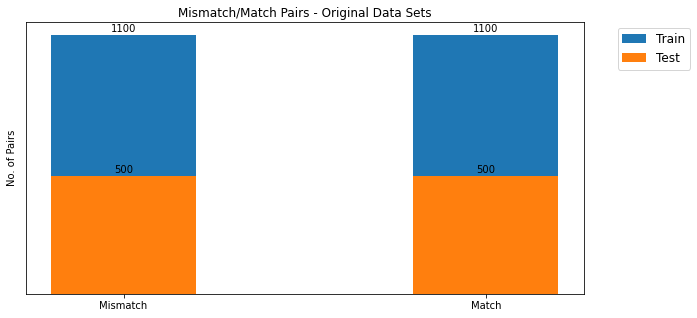

In [10]:
# Define bar plot labels
bar_labels = ["Mismatch", "Match"]

# Create figure
plt.figure(figsize=(10, 5))

# Bar plot of mismatch and match pairs in train set
ax1 = plt.bar(bar_labels, [(train_labels == MISMATCH_LABEL).sum(),
                           (train_labels == MATCH_LABEL).sum()],
              width=0.4,
              label="Train")

# Bar plot of mismatch and match pairs in test set
ax2 = plt.bar(bar_labels, [(test_labels == MISMATCH_LABEL).sum(),
                           (test_labels == MATCH_LABEL).sum()],
              width=0.4,
              label="Test")

# Add labels to bar
plt.bar_label(ax1, fmt="%d", padding=1)
plt.bar_label(ax2, fmt="%d", padding=1)

# Configure figure
plt.xticks([0, 1], labels=bar_labels)
plt.yticks([])
plt.ylabel("No. of Pairs", labelpad=5)
plt.title("Mismatch/Match Pairs - Original Data Sets", pad=5)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize="large")
plt.show()

Next, let's create a validation set (10% out of the training set) and see the number of match and mismatch pairs in each set (train, validation, test):

In [11]:
# split train set to train-validation
train_images_paths, val_images_paths, train_labels, val_labels = (
    train_test_split(train_images_paths,
                     train_labels,
                     test_size=0.1,
                     random_state=0,
                     stratify=train_labels))

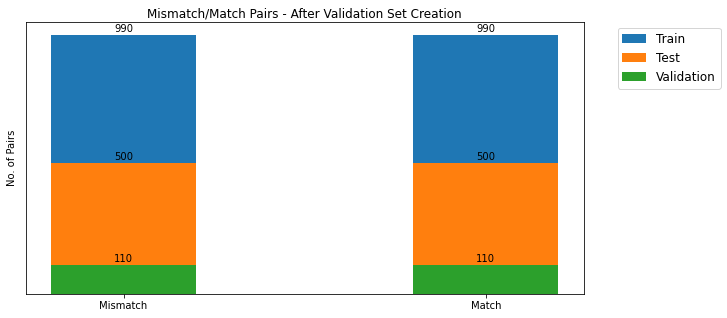

In [12]:
# Define bar plot labels
bar_labels = ["Mismatch", "Match"]

# Create figure
plt.figure(figsize=(10, 5))

# Bar plot of mismatch and match pairs in train set
ax1 = plt.bar(bar_labels, [(train_labels == MISMATCH_LABEL).sum(),
                           (train_labels == MATCH_LABEL).sum()],
              width=0.4,
              label="Train")

# Bar plot of mismatch and match pairs in test set
ax2 = plt.bar(bar_labels, [(test_labels == MISMATCH_LABEL).sum(),
                           (test_labels == MATCH_LABEL).sum()],
              width=0.4,
              label="Test")

# Bar plot of Mismatch and Match pairs in test set
ax3 = plt.bar([0, 1], [(val_labels == MISMATCH_LABEL).sum(),
                       (val_labels == MATCH_LABEL).sum()],
              width=0.4,
              label="Validation")

# Add labels to bar
plt.bar_label(ax1, fmt="%d", padding=1)
plt.bar_label(ax2, fmt="%d", padding=1)
plt.bar_label(ax3, fmt="%d", padding=1)

# Configure figure
plt.xticks([0, 1], labels=bar_labels)
plt.yticks([])
plt.ylabel("No. of Pairs", labelpad=5)
plt.title("Mismatch/Match Pairs - After Validation Set Creation", pad=5)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize="large")
plt.show()

Next, let's visualize some of match pairs:

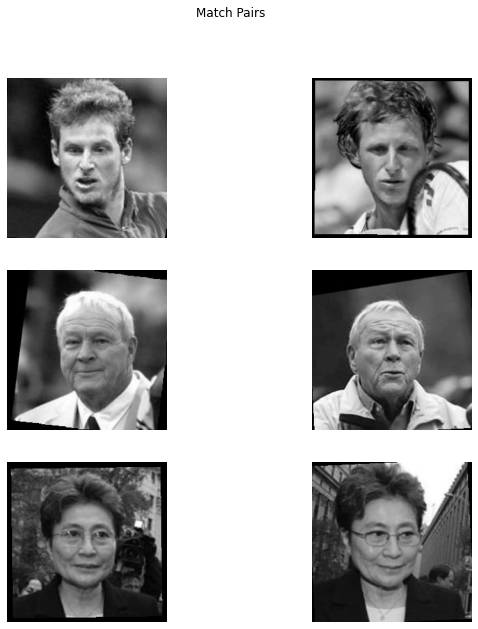

In [13]:
# Create subplot
fig, axes = plt.subplots(3, 2, figsize=(10, 10))

# Loop over 3 match pairs
for i, paths in enumerate(train_images_paths[train_labels == MATCH_LABEL][:3]):
  # Plot pair images
  axes[i, 0].imshow(tf.image.convert_image_dtype(
      read_image(paths[0], ORIGINAL_IMAGE_SHAPE, 1).numpy(), "uint8"),
                    cmap="gray")
  axes[i, 1].imshow(tf.image.convert_image_dtype(
      read_image(paths[1], ORIGINAL_IMAGE_SHAPE, 1).numpy(), "uint8"),
                    cmap="gray")

  # Remove axis
  axes[i, 0].axis('off')
  axes[i, 1].axis('off')

# Add title
fig.suptitle("Match Pairs")
plt.show()

Next, let's visualize some of mismatch pairs:

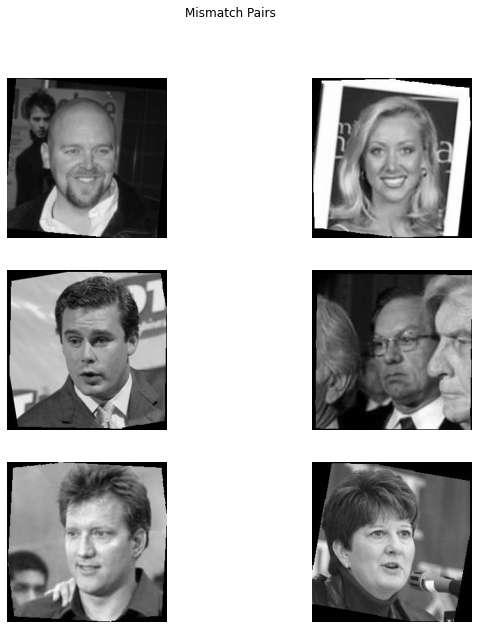

In [14]:
# Create subplot
fig, axes = plt.subplots(3, 2, figsize=(10, 10))

# Loop over 3 match pairs
for i, paths in enumerate(
    train_images_paths[train_labels == MISMATCH_LABEL][:3]):
  # Plot pair images
  axes[i, 0].imshow(tf.image.convert_image_dtype(
      read_image(paths[0], ORIGINAL_IMAGE_SHAPE, 1).numpy(), "uint8"),
                    cmap="gray")
  axes[i, 1].imshow(tf.image.convert_image_dtype(
      read_image(paths[1], ORIGINAL_IMAGE_SHAPE, 1).numpy(), "uint8"),
                    cmap="gray")

  # Remove axis
  axes[i, 0].axis('off')
  axes[i, 1].axis('off')

# Add title
fig.suptitle("Mismatch Pairs")
plt.show()

### ***Koch Et al. siamese neural network architecture***

Loosely implementation of the "Koch, Gregory, Richard Zemel, and Ruslan
Salakhutdinov. "Siamese neural networks for one-shot image recognition."
ICML deep learning workshop. Vol. 2. 2015." scientific paper.

Let's begin with creation of tf.data.Dataset objects for each of the data sets (train, validation, test):


In [15]:
# Define image shape
koch_image_shape = (105, 105, 1)

# Create datasets
train_ds = create_ds(train_images_paths, train_labels, koch_image_shape[:-1],
                     koch_image_shape[-1], BATCH_SIZE, True)
val_ds = create_ds(val_images_paths, val_labels, koch_image_shape[:-1],
                   koch_image_shape[-1], BATCH_SIZE, True)
test_ds = create_ds(test_images_paths, test_labels, koch_image_shape[:-1],
                    koch_image_shape[-1], BATCH_SIZE, False)

Next, let's define the cnn network for extracting features in the siamese network:

In [16]:
# Weights and biases initialization as stated in the paper
conv_weights_initialization = initializers.RandomNormal(mean=0., stddev=0.01)
conv_biases_initialization = initializers.RandomNormal(mean=0.5, stddev=0.01)
dense_weights_initialization = initializers.RandomNormal(mean=0., stddev=0.2)
dense_biases_initialization = initializers.RandomNormal(mean=0.5, stddev=0.01)

# L2 regularization as stated in the paper
conv_l2_regularization = regularizers.L2(0.000002)
dense_l2_regularization = regularizers.L2(0.00001)

# Define cnn feature extractor as stated in the paper
koch_cnn = models.Sequential([
    layers.Conv2D(64, (10, 10),
                  kernel_initializer=conv_weights_initialization,
                  bias_initializer=conv_biases_initialization,
                  kernel_regularizer=conv_l2_regularization),
    layers.ReLU(),
    layers.MaxPool2D(),
    layers.Conv2D(128, (7, 7),
                  kernel_initializer=conv_weights_initialization,
                  bias_initializer=conv_biases_initialization,
                  kernel_regularizer=conv_l2_regularization),
    layers.ReLU(),
    layers.MaxPool2D(),
    layers.Conv2D(128, (4, 4),
                  kernel_initializer=conv_weights_initialization,
                  bias_initializer=conv_biases_initialization,
                  kernel_regularizer=conv_l2_regularization),
    layers.ReLU(),
    layers.MaxPool2D(),
    layers.Conv2D(256, (4, 4),
                  kernel_initializer=conv_weights_initialization,
                  bias_initializer=conv_biases_initialization,
                  kernel_regularizer=conv_l2_regularization),
    layers.ReLU(),
    layers.Flatten(),
    layers.Dense(4096,
                 activation='sigmoid',
                 kernel_initializer=dense_weights_initialization,
                 bias_initializer=dense_biases_initialization,
                 kernel_regularizer=dense_l2_regularization)
], name="Feature_extractor")

Next, let's define the distance function between the two encoded outputs:

In [17]:
# Define L1 distance as stated in the paper
l1_distance = lambda tensor_1, tensor_2: tf.abs(tensor_1 - tensor_2)

Next, let's define the optimizer for the siamese network:

In [18]:
# Define optimizer differs from optimizer stated in the paper
# for simplicity
koch_optimizer = optimizers.Adam(LEARNING_RATE)

Next, let's build the siamese network:

In [19]:
# Create siamese network
siamese_network = build_siamese_network(koch_image_shape, koch_cnn,
                                        koch_optimizer, l1_distance)
# Visualize model architecture
_ = utils.plot_model(siamese_network,
                     to_file="Koch_model.png",
                     show_shapes=True,
                     expand_nested=True)

Next, lets train the siamese network using early stopping and model checkpoints:

In [20]:
# Create Callback to save the best model
checkpoint_filepath = "models/Koch_model"
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor="val_binary_accuracy",
    mode="max",
    save_best_only=True)

# Create Callback for model early stopping
model_es_callback = callbacks.EarlyStopping(monitor='val_loss',
                                            mode='min',
                                            verbose=1,
                                            patience=5,
                                            min_delta=0.2)

# Train siamese network
history = siamese_network.fit(
    x=train_ds,
    validation_data=val_ds,
    epochs=NUM_EPOCHS,
    callbacks=[model_checkpoint_callback, model_es_callback])

# Load the best saved
siamese_network.load_weights(checkpoint_filepath)

# Evalute on train and validation sets
siamese_network.evaluate(train_ds)
siamese_network.evaluate(val_ds)

Epoch 1/200
62/62 [==============================] - 13s 121ms/step - loss: 15.5179 - binary_accuracy: 0.5071 - val_loss: 15.2326 - val_binary_accuracy: 0.5000
Epoch 2/200
62/62 [==============================] - 6s 96ms/step - loss: 14.9681 - binary_accuracy: 0.4985 - val_loss: 14.7004 - val_binary_accuracy: 0.5000
Epoch 3/200
62/62 [==============================] - 5s 88ms/step - loss: 14.4502 - binary_accuracy: 0.5040 - val_loss: 14.1951 - val_binary_accuracy: 0.5000
Epoch 4/200
62/62 [==============================] - 5s 77ms/step - loss: 13.9549 - binary_accuracy: 0.5131 - val_loss: 13.7094 - val_binary_accuracy: 0.5000
Epoch 5/200
62/62 [==============================] - 6s 97ms/step - loss: 13.4849 - binary_accuracy: 0.5202 - val_loss: 13.2563 - val_binary_accuracy: 0.5727
Epoch 6/200
62/62 [==============================] - 5s 88ms/step - loss: 13.0411 - binary_accuracy: 0.5328 - val_loss: 12.8193 - val_binary_accuracy: 0.5318
Epoch 7/200
62/62 [==============================]

[3.9273695945739746, 0.6954545378684998]

Next, let's plot the training history (loss, accuracy):

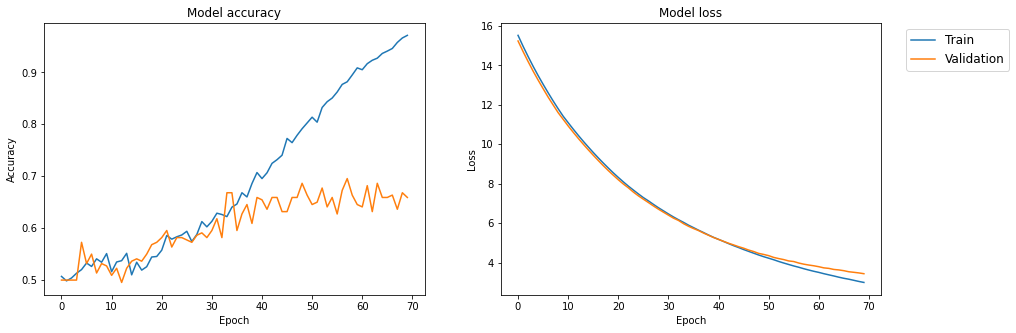

In [21]:
# Create subplot
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
axes[0].plot(history.history['binary_accuracy'])
axes[0].plot(history.history['val_binary_accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')

# Plot Loss
axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')

# Add legend
plt.legend(['Train', 'Validation'],
           bbox_to_anchor=(1.05, 1),
           loc='upper left',
           fontsize="large")
plt.show()

Next, let's test the siamese network: 

In [22]:
# Evalute siamese network
siamese_network.evaluate(test_ds)

32/32 [==============================] - 1s 37ms/step - loss: 3.9874 - binary_accuracy: 0.6260


[3.987422227859497, 0.6259999871253967]

Next, let's see the most correct/incorrect match/mistmatch pairs:

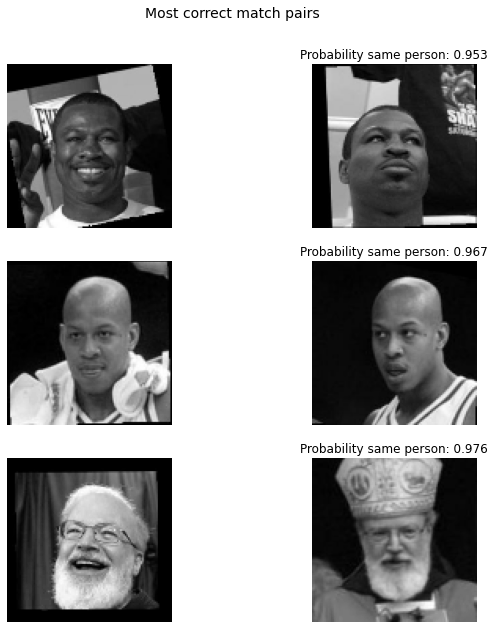

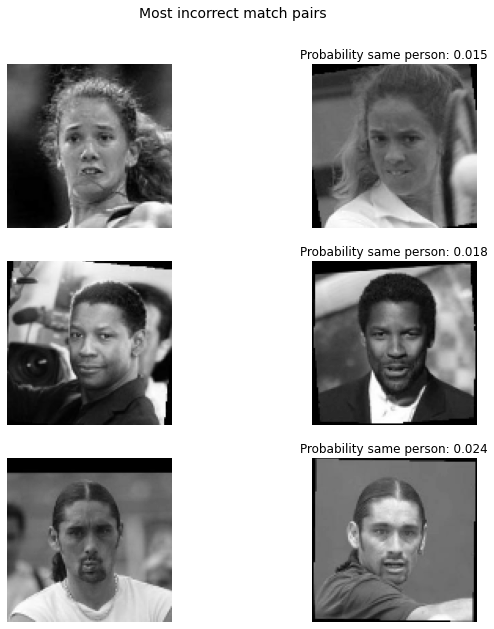

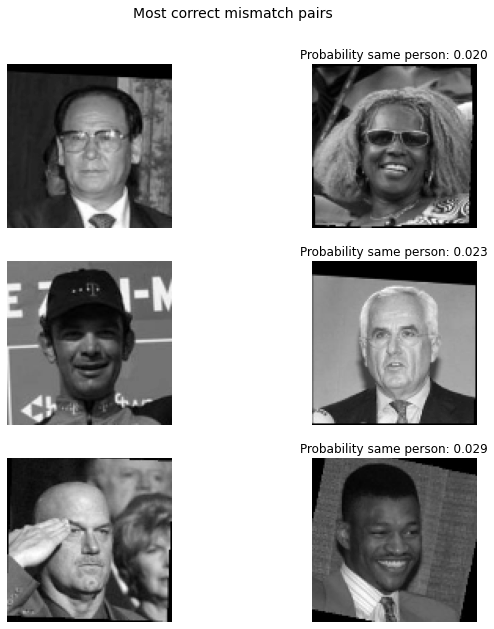

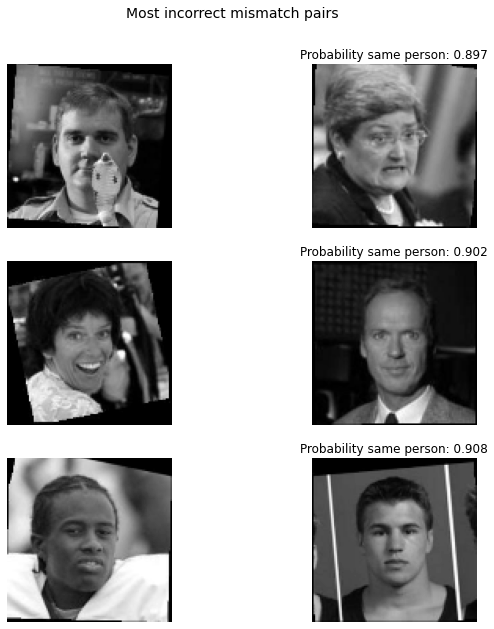

In [23]:
# Define number of pairs we want to visualize
top_k = 3

# Get predictions for test set
predictions = siamese_network.predict(test_ds).squeeze()

# Get all mismatch samples indexes
mismatch_samples_idx = np.where(test_labels == MISMATCH_LABEL)[0]
# Get all mismatch samples predictions sorted
mismatch_predictions = np.argsort(predictions[mismatch_samples_idx])
# Get most incorrect predicted mismatch indexes
most_incorrect_mismatch_idx = mismatch_samples_idx[
    mismatch_predictions[-top_k:]]
# Get most correct predicted mismatch indexes
most_correct_mismatch_idx = mismatch_samples_idx[mismatch_predictions[:top_k]]

# Get all match samples indexes
match_samples_idx = np.where(test_labels == MATCH_LABEL)[0]
# Get all match samples predictions sorted
match_predictions = np.argsort(predictions[match_samples_idx])
# Get most incorrect predicted match indexes
most_incorrect_match_idx = match_samples_idx[match_predictions[:top_k]]
# Get most correct predicted match indexes
most_correct_match_idx = match_samples_idx[match_predictions[-top_k:]]

# visualize predictions
visualize_predictions(top_k, 'Most correct match pairs', predictions,
                      most_correct_match_idx)
visualize_predictions(top_k, 'Most incorrect match pairs', predictions,
                      most_incorrect_match_idx)
visualize_predictions(top_k, 'Most correct mismatch pairs', predictions,
                      most_correct_mismatch_idx)
visualize_predictions(top_k, 'Most incorrect mismatch pairs', predictions,
                      most_incorrect_mismatch_idx)

### ***Koch Et al. improved siamese neural network architecture***

An improved siamese neural network of Koch Et al.

Let's begin with creation of tf.data.Dataset objects for each of the data sets (train, validation, test):


In [24]:
# Define image shape
koch_improved_image_shape = (105, 105, 1)

# Create datasets
train_ds = create_ds(train_images_paths, train_labels,
                     koch_improved_image_shape[:-1],
                     koch_improved_image_shape[-1], BATCH_SIZE, True)
val_ds = create_ds(val_images_paths, val_labels, koch_improved_image_shape[:-1],
                   koch_improved_image_shape[-1], BATCH_SIZE, True)
test_ds = create_ds(test_images_paths, test_labels,
                    koch_improved_image_shape[:-1],
                    koch_improved_image_shape[-1], BATCH_SIZE, False)

Next, let's define the cnn network for extracting features in the siamese network:

In [25]:
# Define cnn feature extractor using batchnormalization, dropout,
# Xavier uniform initializer of weights and biases and witout l2
# regularization
koch_improved_cnn = models.Sequential([
    layers.Conv2D(64, (10, 10)),
    layers.ReLU(),
    layers.MaxPool2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.1),
    layers.Conv2D(128, (7, 7)),
    layers.ReLU(),
    layers.MaxPool2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.1),
    layers.Conv2D(128, (4, 4)),
    layers.ReLU(),
    layers.MaxPool2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.1),
    layers.Conv2D(256, (4, 4)),
    layers.ReLU(),
    layers.Flatten(),
    layers.Dense(4096, activation='sigmoid')
], name="Feature_extractor")

Next, let's define the distance function between the two encoded outputs:

In [26]:
# Define L1 distance as stated in the paper
l1_distance = lambda tensor_1, tensor_2: tf.abs(tensor_1 - tensor_2)

Next, let's define the optimizer for the siamese network:

In [27]:
# Define optimizer differs from optimizer stated in the paper
# for simplicity
koch_improved_optimizer = optimizers.Adam(LEARNING_RATE)

Next, let's build the siamese network:

In [28]:
# Create siamese network
siamese_network = build_siamese_network(koch_improved_image_shape,
                                        koch_improved_cnn,
                                        koch_improved_optimizer, l1_distance)
# Visualize model architecture
_ = utils.plot_model(siamese_network,
                     to_file="Koch_improved_model.png",
                     show_shapes=True,
                     expand_nested=True)

Next, lets train the siamese network using early stopping and model checkpoints:

In [29]:
# Create Callback to save the best model
checkpoint_filepath = "models/Koch_improved_model"
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor="val_binary_accuracy",
    mode="max",
    save_best_only=True)

# Create Callback for model early stopping
model_es_callback = callbacks.EarlyStopping(monitor='val_loss',
                                            mode='min',
                                            verbose=1,
                                            patience=5,
                                            min_delta=0.0001)

# Train siamese network
history = siamese_network.fit(
    x=train_ds,
    validation_data=val_ds,
    epochs=NUM_EPOCHS,
    callbacks=[model_checkpoint_callback, model_es_callback])

# Load the best saved
siamese_network.load_weights(checkpoint_filepath)

# Evalute on train and validation sets
siamese_network.evaluate(train_ds)
siamese_network.evaluate(val_ds)

Epoch 1/200
62/62 [==============================] - 10s 155ms/step - loss: 0.6423 - binary_accuracy: 0.6152 - val_loss: 0.6864 - val_binary_accuracy: 0.6318
Epoch 2/200
62/62 [==============================] - 23s 372ms/step - loss: 0.4516 - binary_accuracy: 0.8187 - val_loss: 0.6707 - val_binary_accuracy: 0.6909
Epoch 3/200
62/62 [==============================] - 15s 252ms/step - loss: 0.3051 - binary_accuracy: 0.9141 - val_loss: 0.6341 - val_binary_accuracy: 0.6591
Epoch 4/200
62/62 [==============================] - 13s 212ms/step - loss: 0.1725 - binary_accuracy: 0.9793 - val_loss: 0.5979 - val_binary_accuracy: 0.7182
Epoch 5/200
62/62 [==============================] - 11s 178ms/step - loss: 0.0905 - binary_accuracy: 0.9960 - val_loss: 0.5919 - val_binary_accuracy: 0.7045
Epoch 6/200
62/62 [==============================] - 14s 219ms/step - loss: 0.0490 - binary_accuracy: 0.9995 - val_loss: 0.5999 - val_binary_accuracy: 0.7045
Epoch 7/200
62/62 [==============================] -

[0.5978566408157349, 0.7181817889213562]

Next, let's plot the training history (loss, accuracy):

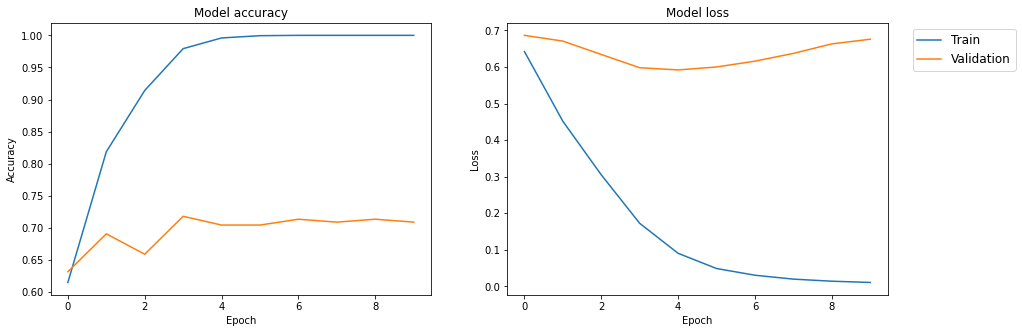

In [30]:
# Create subplot
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
axes[0].plot(history.history['binary_accuracy'])
axes[0].plot(history.history['val_binary_accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')

# Plot Loss
axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')

# Add legend
plt.legend(['Train', 'Validation'],
           bbox_to_anchor=(1.05, 1),
           loc='upper left',
           fontsize="large")
plt.show()

Next, let's test the siamese network: 

In [31]:
# Evalute siamese network
siamese_network.evaluate(test_ds)

32/32 [==============================] - 2s 71ms/step - loss: 0.5818 - binary_accuracy: 0.7100


[0.581843376159668, 0.7099999785423279]

Next, let's see the most correct/incorrect match/mistmatch pairs:

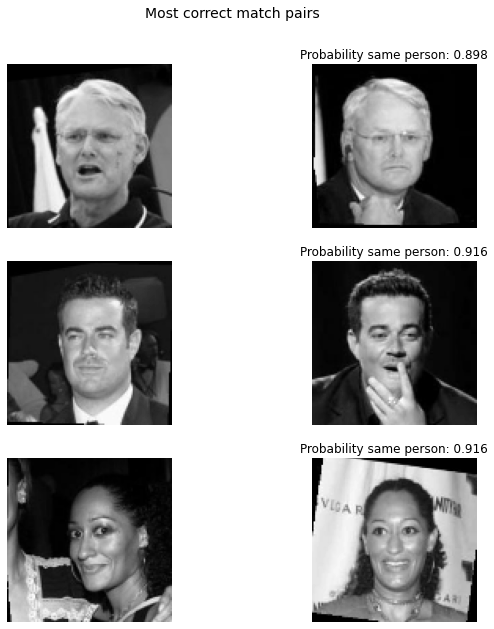

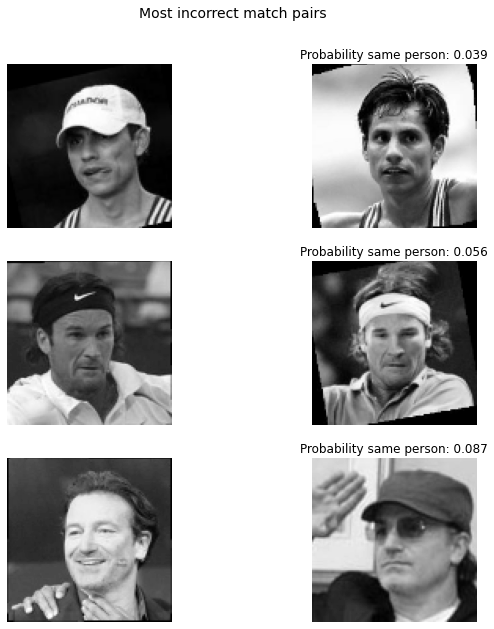

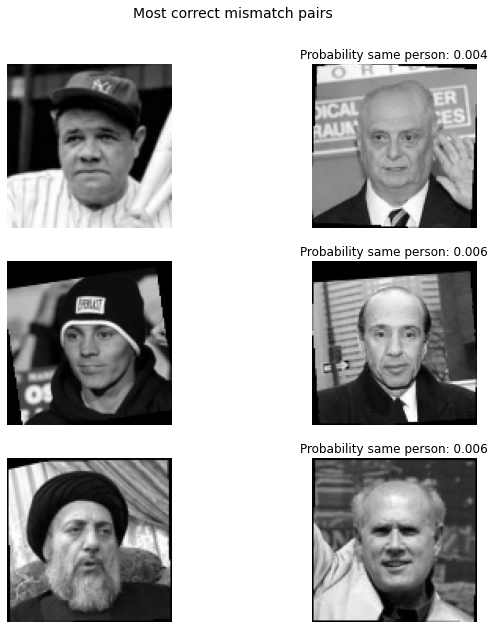

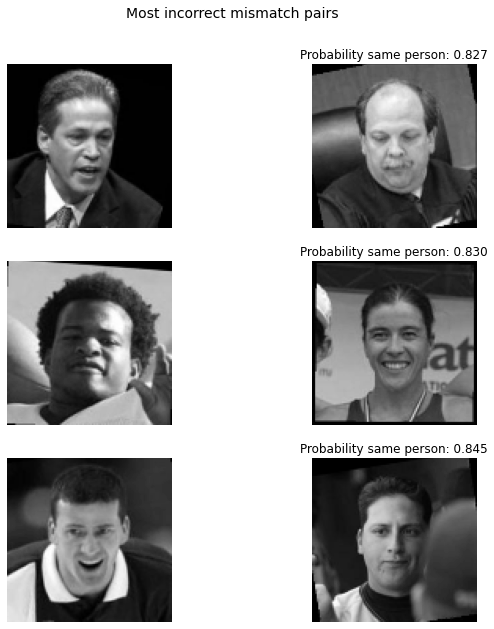

In [32]:
# Define number of pairs we want to visualize
top_k = 3

# Get predictions for test set
predictions = siamese_network.predict(test_ds).squeeze()

# Get all mismatch samples indexes
mismatch_samples_idx = np.where(test_labels == MISMATCH_LABEL)[0]
# Get all mismatch samples predictions sorted
mismatch_predictions = np.argsort(predictions[mismatch_samples_idx])
# Get most incorrect predicted mismatch indexes
most_incorrect_mismatch_idx = mismatch_samples_idx[
    mismatch_predictions[-top_k:]]
# Get most correct predicted mismatch indexes
most_correct_mismatch_idx = mismatch_samples_idx[mismatch_predictions[:top_k]]

# Get all match samples indexes
match_samples_idx = np.where(test_labels == MATCH_LABEL)[0]
# Get all match samples predictions sorted
match_predictions = np.argsort(predictions[match_samples_idx])
# Get most incorrect predicted match indexes
most_incorrect_match_idx = match_samples_idx[match_predictions[:top_k]]
# Get most correct predicted match indexes
most_correct_match_idx = match_samples_idx[match_predictions[-top_k:]]

# visualize predictions
visualize_predictions(top_k, 'Most correct match pairs', predictions,
                      most_correct_match_idx)
visualize_predictions(top_k, 'Most incorrect match pairs', predictions,
                      most_incorrect_match_idx)
visualize_predictions(top_k, 'Most correct mismatch pairs', predictions,
                      most_correct_mismatch_idx)
visualize_predictions(top_k, 'Most incorrect mismatch pairs', predictions,
                      most_incorrect_mismatch_idx)